# Causal Inference Examples
# 1 Foundations
Julian Hsu
Date Made: 5 Aug 2021 

### Table of Contents with Navigation Links
* [Write Causal Models](#Section1)
* [Simulate Data](#Section2)
* [Bootstrapping Examples](#Section3)
* [Bootstrapping Examples - unconfoundedness violation](#Section4)
* [Bootstrapping Examples - overlap violation](#Section5)


In [1]:
import pandas as pd
import numpy as np
import os as os 

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.conditional_models import ConditionalLogit

from IPython.display import display    


import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error


<a id='Section1'></a>

## Write Causal Models
Write several functions here for estimate HTE. Each model _must_ do datasplitting.
These functions will do a lot of predictions, so try to standardize the prediction models.


In [2]:
import stnomics as st

<a id='Section2'></a>

## Bring in Simulated Data
Pretend we've never seen this data before, and do balance checks between treatment and control 

For fun, use the Friedman function: https://www.sfu.ca/~ssurjano/fried.html

In [4]:
def generate_data():
    N = 2000
    
    cov = [[1.00, 0.08, 0.05, 0.05],
           [0.08, 1.00,-0.08,-0.02],
           [0.05,-0.08, 1.00,-0.10],
           [0.05,-0.02,-0.10, 1.00]]
    cov = np.eye(4)
    X = np.random.multivariate_normal(np.zeros(4), cov,N)
    x1,x2,x3,x4= X[:,0],X[:,1],X[:,2],X[:,3]

    treatment_latent = 2*np.sin( np.pi * x4 * x3) + 10*(x2-0.5)**2 - 10*x1
    m,s = np.average(treatment_latent), np.std(treatment_latent)

    treatment_latent = (treatment_latent - m) / s
    
    random_t = np.random.normal(0,1,N)
    
    treatment_latent += random_t
    
    treatment = np.array( np.exp(treatment_latent) / (1+ np.exp(treatment_latent)) > np.random.uniform(0,1,N) ).astype(np.int32)

#     Y = 100 +0.5*x1 - 6*x2 + -2*x4*x1 + 0.5*x1*x2 - 7*(x3+1)**(0.5) + 8/(0.5+x3+x4)
    Y = 100 + 10*np.sin( np.pi * x1 * x2) + 20*(x3-0.5)**2 - 10*x4
#     GT = np.std(Y)
    random_y = np.random.normal(0,1,N)

    GT = 5
    Y += np.random.normal(1,2,N)
    Y += GT*(treatment==1) 
    
    df_est = pd.DataFrame({'x1':x1, 'x2':x2,'x3':x3,'x4':x4,'treatment':treatment, 'Y':Y, 'GT':GT} )
    df_est['x1_2'] = df_est['x1'].pow(2)
    df_est['x2_2'] = df_est['x2'].pow(2)
    df_est['x3_2'] = df_est['x3'].pow(2)
    df_est['x4_2'] = df_est['x4'].pow(2)    
    return df_est

In [5]:
generate_data()

,x1,x2,x3,x4,treatment,Y,GT,x1_2,x2_2,x3_2,x4_2
0,0.313283,-0.489695,0.563628,-0.324982,1,105.700209,5,0.098146,0.239801,0.317676,0.105613
1,-0.347911,0.829529,0.863875,-0.082179,1,102.593495,5,0.121042,0.688119,0.746279,0.006753
2,-1.674069,1.074357,0.852527,0.582977,0,105.036677,5,2.802507,1.154242,0.726802,0.339862
3,0.288611,-0.335995,-1.054658,-0.091539,0,144.336512,5,0.083296,0.112893,1.112303,0.008379
4,-0.972706,0.119425,-1.156609,-0.030407,0,152.401670,5,0.946158,0.014262,1.337744,0.000925
...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.644172,-0.381519,2.104919,-0.124986,0,158.054612,5,0.414957,0.145557,4.430683,0.015621
1996,-0.018871,-1.890406,0.717081,1.377236,1,96.820982,5,0.000356,3.573634,0.514205,1.896778
1997,0.782518,-0.175322,-0.079507,0.643935,1,97.958290,5,0.612335,0.030738,0.006321,0.414652
1998,-1.698061,-0.853848,0.383134,1.211971,1,81.896919,5,2.883411,0.729056,0.146792,1.468875


In [ ]:
model_max_iter = 500
## treatment prediction models
t_models = {}
t_models['LogitCV'] = LogisticRegressionCV(cv=5, random_state=27, n_jobs=-1)
t_models['logit'] = LogisticRegression(penalty='l2',solver='lbfgs', C=1, max_iter=model_max_iter, fit_intercept=True)
t_models['logit_L1_C2'] = LogisticRegression(penalty='l1',C=2, max_iter=model_max_iter, fit_intercept=True)
t_models['logit_L2_C5'] = LogisticRegression(penalty='l2',C=2, max_iter=model_max_iter, fit_intercept=True)
t_models['rf_md10'] = RandomForestClassifier(n_estimators=25,max_depth=10, min_samples_split=200,n_jobs=-1)
t_models['rf_md3'] = RandomForestClassifier(n_estimators=25,max_depth=3, min_samples_split=200,n_jobs=-1)
t_models['nn'] = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1,max_iter=model_max_iter)
## outcome prediction models
y_models = {}
y_models['LassoCV'] = LassoCV(cv=5, n_jobs=-1,  random_state=27)
y_models['ols'] = LinearRegression()
y_models['lasso_a2'] = Lasso(alpha=2,max_iter=model_max_iter)
y_models['ridge_a2'] = Ridge(alpha=2,max_iter=model_max_iter)
y_models['rf_md10'] = RandomForestRegressor(n_estimators=25,max_depth=10, min_samples_split=200,n_jobs=-1)
y_models['rf_md3'] = RandomForestRegressor(n_estimators=25,max_depth=3, min_samples_split=200,n_jobs=-1)
y_models['nn'] = MLPRegressor(alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1, max_iter=model_max_iter)

In [ ]:
n_data_splits = 4
aux_dictionary = {'n_bins': 2, 'n_trees':2, 'max_depth':2, 
                  'upper':0.999, 'lower':0.001,
                  'bootstrapreps':100,
                  'subsample_ratio':0.5}
bootstrap_number = 5


In [ ]:
df = generate_data()

feature_list = [x for x in df.columns if 'x' in x]

ols = st.ate.ols_vanilla(df, 
                'splits', feature_list, 'Y', 'treatment',
                y_models['LassoCV'],t_models['LogitCV'],
               n_data_splits, aux_dictionary )
pbin = st.ate.propbinning(df, 
                'splits', feature_list, 'Y', 'treatment',
                y_models['LassoCV'],t_models['LogitCV'],
               n_data_splits, aux_dictionary )
plm = st.ate.dml.dml_plm(df, 
                'splits', feature_list, 'Y', 'treatment',
                y_models['LassoCV'],t_models['LogitCV'],
               n_data_splits, aux_dictionary )
irm = st.ate.dml.dml_irm(df, 
                'splits', feature_list, 'Y', 'treatment',
                y_models['LassoCV'],t_models['LogitCV'],
               n_data_splits, aux_dictionary )
ip = st.ate.ipw(df, 
                'splits', feature_list, 'Y', 'treatment',
                y_models['LassoCV'],t_models['LogitCV'],
               n_data_splits, aux_dictionary )

In [ ]:
df = generate_data()
df['splits'] = np.random.choice(n_data_splits, len(df), replace=True)
df = df.sort_values(by='splits')    

## Predict Treatment
that = st.predict_treatment_indicator(df, 'splits', n_data_splits, feature_list,'treatment',t_models['LogitCV'])
df['that'] = that
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(9,3), sharex=True, sharey=True)
ax.hist(df.loc[df.treatment==1]['that'], density=False, facecolor='g', alpha=0.25)
ax.hist(df.loc[df.treatment==0]['that'], density=False, facecolor='b', alpha=0.25)
control_range_to_remove = np.percentile(df.loc[df.treatment==1]['that'], q= 50) , np.percentile(df.loc[df.treatment==1]['that'], q= 99)
print(control_range_to_remove)

df = df.loc[ (df.treatment==1) | ( (df.that.between(control_range_to_remove[0],control_range_to_remove[1])==False) & (df.treatment==0) )   ]
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(9,3), sharex=True, sharey=True)
ax.hist(df.loc[df.treatment==1]['that'], density=False, facecolor='g', alpha=0.25)
ax.hist(df.loc[df.treatment==0]['that'], density=False, facecolor='b', alpha=0.25)


<a id='Section4'></a>

## Bootstrapping
* Bootstrap results using random datasets when all three assumptions are satisfied.
* Bootstrap results when the unconfoundedness assumption is violated. Do this by removing one fot the features from training.
* Bootstrap results when the overlap assumption is violated. Do this by removing control observations with propensities near the median treatment obervation propensity.

In [ ]:
ols_x = []
pbin_x= []
plm_x = []
irm_x = []
ipw_x = []

ols_x_unconf = []
pbin_x_unconf= []
plm_x_unconf = []
irm_x_unconf = []
ipw_x_unconf = []

ols_x_overlap = []
pbin_x_overlap= []
plm_x_overlap = []
irm_x_overlap = []
ipw_x_overlap = []

In [ ]:
for b in range(bootstrap_number):
    df = generate_data()
    
    feature_list = [x for x in df.columns if 'x' in x]
    
    feature_list_ab = [x for x in feature_list if '3' not in x and '4' not in x]
    
    ## Regular 
    ols = st.ate.ols_vanilla(df, 
                    'splits', feature_list, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    pbin = st.ate.propbinning(df, 
                    'splits', feature_list, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    plm = st.ate.dml.dml_plm(df, 
                    'splits', feature_list, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    irm = st.ate.dml.dml_irm(df, 
                    'splits', feature_list, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    ip = st.ate.ipw(df, 
                'splits', feature_list, 'Y', 'treatment',
                y_models['LassoCV'],t_models['LogitCV'],
               n_data_splits, aux_dictionary )
    ols_x.append(ols['ATE TE'])
    pbin_x.append(pbin['ATE TE'])
    plm_x.append(plm['ATE TE'])
    irm_x.append(irm['ATE TE'])    
    ipw_x.append(ip['ATE TE'])   
    
    ## When unconfoundedness assumption is not true
    ols = st.ate.ols_vanilla(df, 
                    'splits', feature_list_ab, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    pbin = st.ate.propbinning(df, 
                    'splits', feature_list_ab, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    plm = st.ate.dml.dml_plm(df, 
                    'splits', feature_list_ab, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    irm = st.ate.dml.dml_irm(df, 
                    'splits', feature_list_ab, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    ip = st.ate.ipw(df, 
                'splits', feature_list_ab, 'Y', 'treatment',
                y_models['LassoCV'],t_models['LogitCV'],
               n_data_splits, aux_dictionary )
    ols_x_unconf.append(ols['ATE TE'])
    pbin_x_unconf.append(pbin['ATE TE'])
    plm_x_unconf.append(plm['ATE TE'])
    irm_x_unconf.append(irm['ATE TE'])    
    ipw_x_unconf.append(ip['ATE TE'])        


    ## When overlap condition is not true
    df['splits'] = np.random.choice(n_data_splits, len(df), replace=True)
    df = df.sort_values(by='splits')    
    ## Predict Treatment
    that = st.predict_treatment_indicator(df, 'splits', n_data_splits, feature_list,'treatment',t_models['LogitCV'])
    df['that'] = that    
    control_range_to_remove = np.percentile(df.loc[df.treatment==1]['that'], q= 50) , np.percentile(df.loc[df.treatment==1]['that'], q= 99)
    df = df.loc[ (df.treatment==1) | ( (df.that.between(control_range_to_remove[0],control_range_to_remove[1])==False) & (df.treatment==0) )   ]


    ols = st.ate.ols_vanilla(df, 
                    'splits', feature_list, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    pbin = st.ate.propbinning(df, 
                    'splits', feature_list, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    plm = st.ate.dml.dml_plm(df, 
                    'splits', feature_list, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    irm = st.ate.dml.dml_irm(df, 
                    'splits', feature_list, 'Y', 'treatment',
                    y_models['LassoCV'],t_models['LogitCV'],
                   n_data_splits, aux_dictionary )
    ip = st.ate.ipw(df, 
                'splits', feature_list, 'Y', 'treatment',
                y_models['LassoCV'],t_models['LogitCV'],
               n_data_splits, aux_dictionary )

    ols_x_overlap.append(ols['ATE TE'])
    pbin_x_overlap.append(pbin['ATE TE'])
    plm_x_overlap.append(plm['ATE TE'])
    irm_x_overlap.append(irm['ATE TE'])    
    ipw_x_overlap.append(ip['ATE TE'])        

ols_x = np.array(ols_x) - 5
pbin_x = np.array(pbin_x) - 5
plm_x = np.array(plm_x) - 5
irm_x = np.array(irm_x) - 5
ipw_x = np.array(ipw_x) - 5

ols_x_unconf = np.array(ols_x_unconf) - 5
pbin_x_unconf = np.array(pbin_x_unconf) - 5
plm_x_unconf = np.array(plm_x_unconf) - 5
irm_x_unconf = np.array(irm_x_unconf) - 5
ipw_x_unconf = np.array(ipw_x_unconf) - 5    

ols_x_overlap = np.array(ols_x_overlap) - 5
pbin_x_overlap = np.array(pbin_x_overlap) - 5
plm_x_overlap = np.array(plm_x_overlap) - 5
irm_x_overlap = np.array(irm_x_overlap) - 5
ipw_x_overlap = np.array(ipw_x_overlap) - 5    


In [ ]:
ols_x

In [ ]:
def print_avg_med_iqr(x):
    avg = np.average(x)
    p50 = np.percentile(x, 50)
    p25 = np.percentile(x, 25)
    p75 = np.percentile(x, 75)    
    print('AVG: {0:5.2f}   MED: {1:5.2f}   IQR: [{2:5.3f}, {3:5.2f}]'.format(avg, p50, p25, p75))

In [ ]:
print('Bias when all assumptions are met')
print_avg_med_iqr(ols_x)    
print_avg_med_iqr(pbin_x)    
print_avg_med_iqr(plm_x)    
print_avg_med_iqr(irm_x)    
print_avg_med_iqr(ipw_x)    

print('')
print('Bias when unconfoundedness is not met')
print_avg_med_iqr(ols_x_unconf) 
print_avg_med_iqr(pbin_x_unconf)    
print_avg_med_iqr(plm_x_unconf)    
print_avg_med_iqr(irm_x_unconf)    
print_avg_med_iqr(ipw_x_unconf)    

print('')
print('Bias when overlap is not met')
print_avg_med_iqr(ols_x_overlap)    
print_avg_med_iqr(pbin_x_overlap)    
print_avg_med_iqr(plm_x_overlap)    
print_avg_med_iqr(irm_x_overlap)    
print_avg_med_iqr(ipw_x_overlap[~np.isnan(ipw_x_overlap)])    


<a id='Section5'></a>

## Prediction vs Causal
Let's compare the estimated treatment effects $\hat{Y}(W=1) - \hat{Y}(W=0) $ among ML models. Let's use the treatment effect of multiple features.

We expect to find evidence of regularization bias. As demonstrated in **Figure 1** of Chernozhukov et al., "*Double/Debiased Machine Learning for Treatment and Structural Parameters*" (https://arxiv.org/pdf/1608.00060.pdf) 

In [3]:
def sim_data(WDim=2,
             TE = [1,1],
             N = 50):
    corr = False
    if corr==False:
        pass
    else:
        x = np.random.uniform(0,1,N)
        
    for r in range(WDim+1):
        if corr==False:
            W = np.random.randint(0,2, N)     
        else: 
            x1 = np.random.uniform(-1,1,N)                
            W = ( ( np.exp(x + x1) / (1+ np.exp(x+x1)) ) > np.random.uniform(0.45,0.55) ).astype(float)
        if r ==0:
            Y = TE[r]*W + np.random.normal(0,1, N)
            data_dict = {'W1':W}
        else:
            Y = TE[r]*W
            data_dict['W'+str(r)] = W
    data_dict['Y'] = Y
    return pd.DataFrame(data=data_dict, index=np.arange(N))
#     if corr==False:
#         W1 = np.random.randint(0,2, N) 
#         W2 = np.random.randint(0,2, N)     
#     else:
#         x = np.random.uniform(0,1,N)
#         x1 = np.random.uniform(-1,1,N)
#         x2 = np.random.uniform(-1,1,N)        
#         W1 = ( ( np.exp(x + x1) / (1+ np.exp(x+x1)) ) > np.random.uniform(0.45,0.55) ).astype(float)
#         W2 = ( ( np.exp(x + x2) / (1+ np.exp(x+x2)) ) > np.random.uniform(0.45,0.55) ).astype(float)        


#     Y = TE[0]*W1 + TE[1]*W2 + np.random.normal(0,1, N)
#     return pd.DataFrame(data={'Y':Y, 'W1':W1, 'W2': W2}, index=np.arange(N))


In [8]:
def ml_te(X, WDim, func):
    trained = func.fit(X[[x for x in X.columns if 'W' in x]], X['Y'])
    te_output = {}
    for r in range(WDim+1):
        T = np.zeros(WDim)
        T[r-1] = 1
        te_output[str(r)] = trained.predict([T])[0] - trained.predict([np.zeros(WDim)])[0]
#     te1 = trained.predict([[1,0]]) - trained.predict([[0,0]])
#     te2 = trained.predict([[0,1]]) - trained.predict([[0,0]])    
    return te_output

In [9]:
nn2 = MLPRegressor(hidden_layer_sizes=(2,), max_iter = 2000, random_state=4227)
nn10 = MLPRegressor(hidden_layer_sizes=(10,), max_iter = 2000, random_state=4227)
ols = LinearRegression()
rf1000 = RandomForestRegressor(n_estimators=1000)
rf100 = RandomForestRegressor(n_estimators=100)

In [29]:

WDim_use = 5
TE_use = [0.50]*(WDim_use+1)
sim_range = 500


In [30]:
## Generate Data and simulate many OLS and other estimates
dict_est = {}
for w in range(WDim_use):
    dict_est[str(w)] = {'OLS':[], 'NN2':[], 'NN10':[], 'RF1000':[], 'RF100':[]  }

for r in range(sim_range):
    df = sim_data(WDim=WDim_use, TE = TE_use, N = 1000)
    # display(df.describe())
    ols_HAT = ml_te(df,   WDim_use, ols)
    nn2_HAT = ml_te(df,   WDim_use, nn2)
    nn10_HAT = ml_te(df,  WDim_use, nn10)
    rf1000_HAT = ml_te(df,WDim_use, rf1000)
    rf100_HAT = ml_te(df, WDim_use, rf100)
    for w in range(WDim_use):
        dict_est[str(w)]['OLS'].append(ols_HAT[str(w)])
        dict_est[str(w)]['NN2'].append(nn2_HAT[str(w)])
        dict_est[str(w)]['NN10'].append(nn10_HAT[str(w)])
        dict_est[str(w)]['RF1000'].append(rf1000_HAT[str(w)])
        dict_est[str(w)]['RF100'].append(rf100_HAT[str(w)])
        

In [31]:
for w in range(WDim_use):
    print('For Parameter {0}'.format(w))
    for a in ['OLS','NN2','NN10','RF1000','RF100']:
        print(a)
        est1_bias = np.abs( np.mean(dict_est[str(w)][a] ) - TE_use[w] )
        print(' |Bias| of Est = {0:5.3} using {1}'.format(est1_bias, a))
    


For Parameter 0
OLS
 |Bias| of Est =   0.0 using OLS
NN2
 |Bias| of Est =   0.5 using NN2
NN10
 |Bias| of Est = 0.141 using NN10
RF1000
 |Bias| of Est =   0.0 using RF1000
RF100
 |Bias| of Est =   0.0 using RF100
For Parameter 1
OLS
 |Bias| of Est =   0.5 using OLS
NN2
 |Bias| of Est = 0.502 using NN2
NN10
 |Bias| of Est = 0.489 using NN10
RF1000
 |Bias| of Est =   0.5 using RF1000
RF100
 |Bias| of Est =   0.5 using RF100
For Parameter 2
OLS
 |Bias| of Est =   0.5 using OLS
NN2
 |Bias| of Est = 0.587 using NN2
NN10
 |Bias| of Est = 0.524 using NN10
RF1000
 |Bias| of Est =   0.5 using RF1000
RF100
 |Bias| of Est =   0.5 using RF100
For Parameter 3
OLS
 |Bias| of Est =   0.5 using OLS
NN2
 |Bias| of Est = 0.412 using NN2
NN10
 |Bias| of Est = 0.508 using NN10
RF1000
 |Bias| of Est =   0.5 using RF1000
RF100
 |Bias| of Est =   0.5 using RF100
For Parameter 4
OLS
 |Bias| of Est =   0.5 using OLS
NN2
 |Bias| of Est = 0.568 using NN2
NN10
 |Bias| of Est = 0.502 using NN10
RF1000
 |Bias| of E

Text(0.5, 1.0, 'Estimate 2')

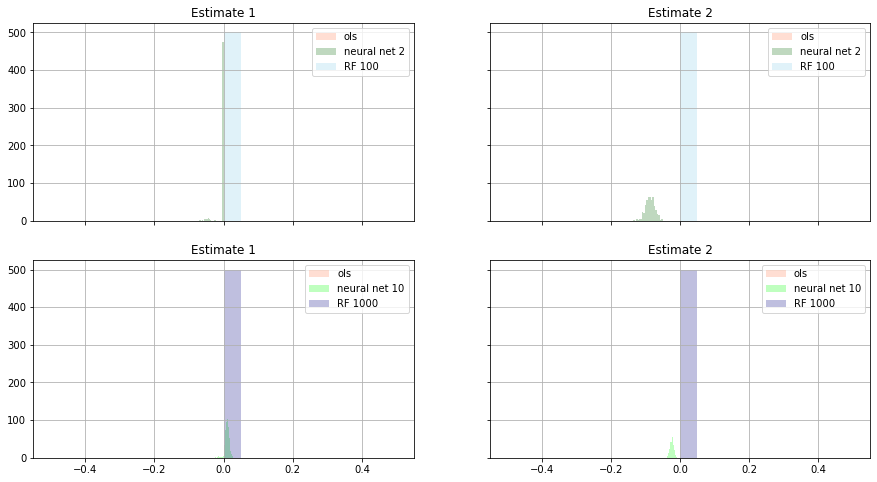

In [32]:
fig,ax = plt.subplots(nrows=2,ncols=2, figsize=(15,8), sharex=True, sharey=True)
ax[0,0].hist(dict_est['1']['OLS'],   bins=20, density=False,  label='ols',           alpha=0.25, color='coral')
ax[0,0].hist(dict_est['1']['NN2'],   bins=20, density=False,  label='neural net 2',  alpha=0.25, color='darkgreen')
# ax[0,0].hist(dict_est['1']['NN10'],  bins=20, density=False,  label='neural net 10', alpha=0.25, color='lime')
# ax[0,0].hist(dict_est['1']['RF1000'],bins=20, density=False,  label='RF 1000',       alpha=0.25,  color='navy')
ax[0,0].hist(dict_est['1']['RF100'], bins=20, density=False,  label='RF 100',        alpha=0.25,  color='skyblue')
# ax[0,0].vlines(TE_use[0], 0, 10, colors='black', label='Truth')
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_title('Estimate 1')

ax[1,0].hist(dict_est['1']['OLS'],   bins=20, density=False,  label='ols',           alpha=0.25, color='coral')
# ax[1,0].hist(dict_est['1']['NN2'],   bins=20, density=False,  label='neural net 2',  alpha=0.25, color='darkgreen')
ax[1,0].hist(dict_est['1']['NN10'],  bins=20, density=False,  label='neural net 10', alpha=0.25, color='lime')
ax[1,0].hist(dict_est['1']['RF1000'],bins=20, density=False,  label='RF 1000',       alpha=0.25,  color='navy')
# ax[1,0].hist(dict_est['1']['RF100'], bins=20, density=False,  label='RF 100',        alpha=0.25,  color='skyblue')
# ax[1,0].vlines(TE_use[0], 0, 10, colors='black', label='Truth')
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].set_title('Estimate 1')

ax[0,1].hist(dict_est['2']['OLS'],   bins=20, density=False, label='ols',           alpha=0.25, color='coral')
ax[0,1].hist(dict_est['2']['NN2'],   bins=20, density=False, label='neural net 2',  alpha=0.25, color='darkgreen')
# ax[0,1].hist(dict_est['2']['NN10'],  bins=20, density=False, label='neural net 10', alpha=0.25, color='lime')
# ax[0,1].hist(dict_est['2']['RF1000'],bins=20, density=False, label='RF 1000',       alpha=0.25,  color='navy')
ax[0,1].hist(dict_est['2']['RF100'], bins=20, density=False, label='RF 100',        alpha=0.25,  color='skyblue')
# ax[0,1].vlines(TE_use[1], 0, 10, colors='black', label='Truth')
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].set_title('Estimate 2')

ax[1,1].hist(dict_est['2']['OLS'],   bins=20, density=False, label='ols',           alpha=0.25, color='coral')
# ax[1,1].hist(dict_est['2']['NN2'],   bins=20, density=False, label='neural net 2',  alpha=0.25, color='darkgreen')
ax[1,1].hist(dict_est['2']['NN10'],  bins=20, density=False, label='neural net 10', alpha=0.25, color='lime')
ax[1,1].hist(dict_est['2']['RF1000'],bins=20, density=False, label='RF 1000',       alpha=0.25,  color='navy')
# ax[1,1].hist(dict_est['2']['RF100'], bins=20, density=False, label='RF 100',        alpha=0.25,  color='skyblue')
# ax[1,1].vlines(TE_use[1], 0, 10, colors='black', label='Truth')
ax[1,1].legend()
ax[1,1].grid()
ax[1,1].set_title('Estimate 2')
